# Nanocrystal Segmentation

This notebook demonstrates two approaches to nanocrystal segmentation:
1. Virtual dark-field (VDF) imaging-based segmentation
2. Non-negative matrix factorisation (NMF)-based segmentation

The segmentation is demonstrated on a SPED dataset of partly overlapping MgO nanoparticles, where some of the particles share the same orientation.

This functionality has been checked to run with pyxem-0.15.0 (April 2023). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

1. <a href='#gen'> Setting up, Loading Data, Pre-processing</a>
2. <a href='#vdf'> Virtual Image Based Segmentation</a>
3. <a href='#nmf'> NMF Based Segmentation</a>

<a id='gen'></a>

## 1. Setting up, Loading Data, Pre-processing

Import pyxem and other required libraries

In [1]:
%matplotlib inline
import numpy as np
import hyperspy.api as hs
import matplotlib.pyplot as plt
import pyxem as pxm

Load demonstration data

In [2]:
dp = hs.load('./data/06/mgo_nanoparticles.hdf5', reader="hspy")

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


Set the Calibrations...

In [3]:
scale = 0.03246*2 
scale_real = 3.03*2
dp.set_diffraction_calibration(scale)
dp.set_scan_calibration(scale_real)

Plot data to inspect

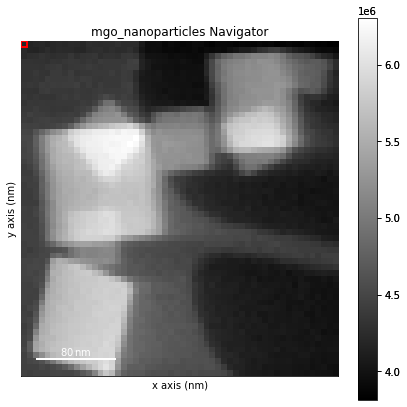

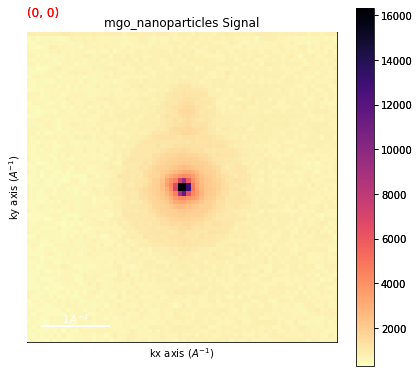

In [4]:
%matplotlib inline
dp.plot(cmap='magma_r')

Remove the background

In [5]:
sigma_min = 1.7
sigma_max = 13.2

dp_rb= dp.subtract_diffraction_background('difference of gaussians', 
                             min_sigma=sigma_min, 
                             max_sigma=sigma_max)
dp_rb.set_signal_type("electron_diffraction") # This will be fixed with pyxem/pyxem#889

Plot the background subtracted data

[########################################] | 100% Completed |  0.8s


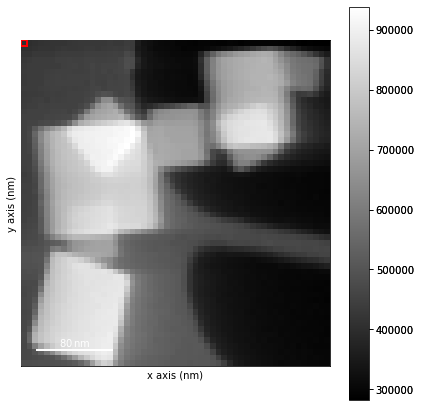

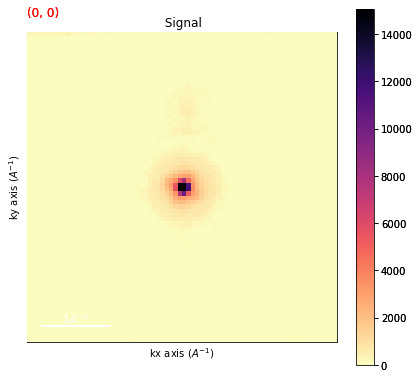

In [6]:
dp_rb.plot(cmap='magma_r')

Find the position of the direct beam in the background subtracted data.

In [7]:
shifts  = dp_rb.get_direct_beam_position(method='blur',
                                         signal_slice=(-.4, .4,-.4,.4),
                                         sigma=2,)

In [8]:
shifts

<LazyBeamShift, title: , dimensions: (54, 57|2)>

In [9]:
# this step is likely to be quiet slow
shifts.compute()

[########################################] | 100% Completed |  2.1s


Visualizing the shifts.  This gives us a better idea of what the shifts look like.

In this case the shifts are small (1 pixel or zero pixels in most cases)

[<AxesSubplot:title={'center':' (0,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':' (1,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

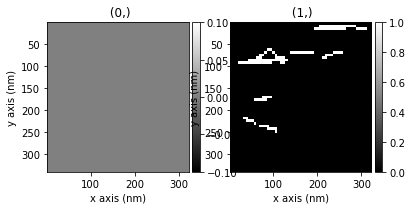

In [10]:
hs.plot.plot_images(shifts.T)

Apply the same shifts to the raw data.

In [11]:
dp_shifted = dp_rb.center_direct_beam(shifts=shifts, inplace=False)

In [12]:
dp_shifted.compute()

[########################################] | 100% Completed |  1.0s


<a id='vdf'></a>

##  2. Virtual Image Based Segmentation

### 2.1. Peak Finding & Refinement

Find all diffraction peaks for all PED patterns. 
The parameters were found by interactive peak finding:

`peaks = dp_rb.find_peaks_interactive(imshow_kwargs={'cmap': 'magma_r'})`

In [13]:
import hyperspy
hyperspy.__version__

'1.7.4'

In [14]:
dp_shifted.data = dp_shifted.data/dp_shifted.max(axis=(0,1,2,3)).data

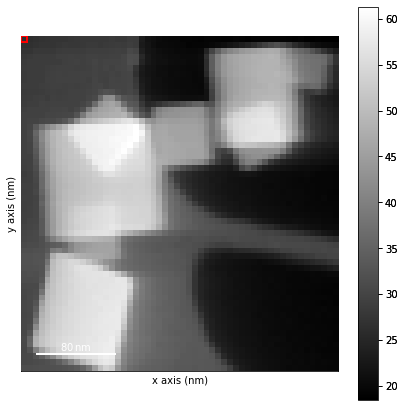

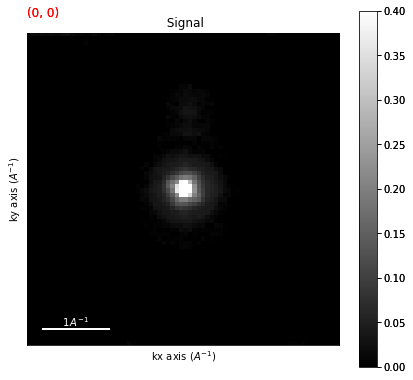

In [15]:
dp_shifted.plot(vmax=.4)

In [16]:
peaks = dp_shifted.find_peaks(method='minmax',
                         threshold=.03,
                         distance=3,
                         
                         interactive=False)

[########################################] | 100% Completed |  1.8s


Visualise the number of diffraction peaks found at each probe position

In [17]:
from pyxem.signals.diffraction_vectors import DiffractionVectors
peaks = DiffractionVectors.from_peaks(peaks,center=(36,36),calibration=scale)

[########################################] | 100% Completed |  0.1s


[########################################] | 100% Completed |  0.1s


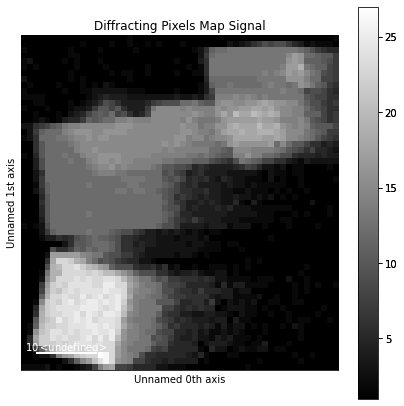

In [18]:
diff_map = peaks.get_diffracting_pixels_map()
diff_map.plot()

Exclude peaks too close to the detector edge for sub-pixel refinement. 

In [19]:
peaks.flatten_diffraction_vectors(real_units=False)

<DiffractionVectors2D, title: , dimensions: (|4, 23409)>

In [20]:
peaks.detector_shape = dp.axes_manager.signal_shape

In [21]:
peaks.scales[0]*(peaks.detector_shape[0]/2) - peaks.scales[0]*2

2.20728

In [22]:
peaks_filtered = peaks.filter_detector_edge(exclude_width=5)

[########################################] | 100% Completed |  0.1s


Refine the peak positions using center of mass

In [23]:
from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from pyxem.signals.diffraction_vectors import DiffractionVectors


refine_gen = SubpixelrefinementGenerator(dp_rb, peaks_filtered)

peaks_refined = DiffractionVectors(refine_gen.center_of_mass_method(square_size=4))


[########################################] | 100% Completed |  0.1s


In [24]:
peaks_filtered.scales

[0.06492, 0.06492]

### 2.2. Determine Unique Peaks

Determine the unique diffraction peaks by clustering

In [25]:
peaks_filtered.scales

[0.06492, 0.06492]

In [26]:
def replace_nan(data):
    new_data = data
    new_data[np.isnan(data)]=0
    return np.array(new_data)

In [27]:
peaks_refined = peaks_refined.map(replace_nan, inplace=False, ragged=True)

[########################################] | 100% Completed |  0.1s


In [28]:
peaks_refined.scales

In [29]:
peaks_refined.set_signal_type("diffraction_vectors")

In [30]:
distance_threshold = scale*0.89*2
min_samples = 10

unique_peaks = peaks_refined.get_unique_vectors(method='DBSCAN',
                                                distance_threshold=distance_threshold,
                                                min_samples=min_samples)
print(np.shape(unique_peaks.data)[0], ' unique vectors were found.')

39  unique vectors were found.


Visualise the detected unique peaks by plotting them on the maximum of the signal. 

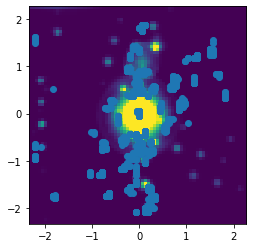

In [31]:
all_pos = np.array([i for ind in np.ndindex(peaks.data.shape) for i in peaks_refined.data[ind] ])
plt.figure()
plt.scatter(all_pos[:,1],all_pos[:, 0])
plt.imshow(dp_rb.mean().data, extent=dp_rb.axes_manager.signal_extent, vmax=1000)
plt.show()

In [32]:
peaks_refined.scales

In [33]:
radius_px = dp_rb.axes_manager.signal_shape[0]/2
reciprocal_radius = radius_px * scale

In [34]:
dp_rb.axes_manager.signal_extent

(-2.33712, 2.2722, -2.33712, 2.2722)

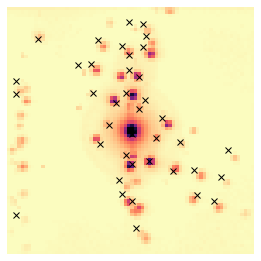

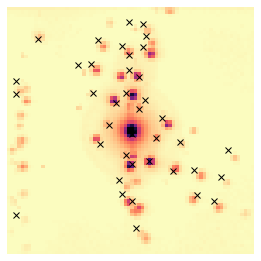

In [35]:
peaks_refined.plot_diffraction_vectors(
    method='DBSCAN',
    unique_vectors=unique_peaks,
    distance_threshold=distance_threshold,
    xlim=reciprocal_radius,
    ylim=reciprocal_radius,
    min_samples=min_samples,
    image_to_plot_on=dp_rb.max(),
    image_cmap='magma_r',
    plot_label_colors=False)

Visualise both the clusters and the unique peaks obtained after DBSCAN clustering. 

*NB The cluster colors are randomly generated, so run it again if it is hard to discern two close clusters.*

Filter the unique vectors by magnitude in order to exclude the direct beam from the following analysis

In [36]:
Gs = unique_peaks.filter_magnitude(min_magnitude=10*scale,
                                   max_magnitude=np.inf)
print(np.shape(Gs)[0], ' unique vectors.')

29  unique vectors.


This gets us a set of basis vectors.  We can then plot where these vectors exsist in the dataset. 

In [37]:
filtered = peaks_refined.filter_basis(Gs.data, distance=0.1, inplace=False)

[########################################] | 100% Completed |  0.1s


Optionally save and load the unique peaks

In [38]:
Gs.save("peaks.hspy", overwrite=True)

In [39]:
hs.load("peaks.hspy")

<DiffractionVectors2D, title: , dimensions: (|2, 29)>

### 2.3. Virtual Imaging & Segmentation

Calculate VDF images for all unique peaks

In [40]:
from pyxem.generators import VirtualDarkFieldGenerator

radius=scale*2

vdfgen = VirtualDarkFieldGenerator(dp_rb, Gs)
VDFs = vdfgen.get_virtual_dark_field_images(radius=radius)
print(VDFs.vectors)
#VDFs.compute()
print(VDFs.vectors)
VDFs.metadata

<DiffractionVectors2D, title: , dimensions: (|2, 29)>
<DiffractionVectors2D, title: , dimensions: (|2, 29)>


├── Diffraction
│   └── roi_list <list>
│       ╠══ [0] = CircleROI(cx=-2.07744, cy=-0.06492, r=0.12984, r_inner=0)
│       ╠══ [1] = CircleROI(cx=-2.03756, cy=0.20277, r=0.12984, r_inner=0)
│       ╠══ [10] = CircleROI(cx=-1.17147, cy=-0.06492, r=0.12984, r_inner=0)
│       ╠══ [11] = CircleROI(cx=-0.730211, cy=-0.127401, r=0.12984, r_inner=0)
│       ╠══ [12] = CircleROI(cx=-1.03843, cy=0.12984, r=0.12984, r_inner=0)
│       ╠══ [13] = CircleROI(cx=-0.960816, cy=-2.20728, r=0.12984, r_inner=0)
│       ╠══ [14] = CircleROI(cx=-0.736649, cy=-0.746933, r=0.12984, r_inner=0)
│       ╠══ [15] = CircleROI(cx=-0.711716, cy=-2.20728, r=0.12984, r_inner=0)
│       ╠══ [16] = CircleROI(cx=-0.607185, cy=0.239604, r=0.12984, r_inner=0)
│       ╠══ [17] = CircleROI(cx=0.195794, cy=0.908523, r=0.12984, r_inner=0)
│       ╠══ [18] = CircleROI(cx=0.332947, cy=1.81776, r=0.12984, r_inner=0)
│       ╠══ [19] = CircleROI(cx=0.731048, cy=0.764287, r=0.12984, r_inner=0)
│       ╠══ [2] = CircleROI(cx=-1.81173, cy=0.264317, r=0.12984, r_inner=0)
│       ╠══ [20] = CircleROI(cx=0.710855, cy=1.16856, r=0.12984, r_inner=0)
│       ╠══ [21] = CircleROI(cx=0.843625, cy=1.68692, r=0.12984, r_inner=0)
│       ╠══ [22] = CircleROI(cx=0.912099, cy=-0.244657, r=0.12984, r_inner=0)
│       ╠══ [23] = CircleROI(cx=1.18356, cy=1.22185, r=0.12984, r_inner=0)
│       ╠══ [24] = CircleROI(cx=1.18182, cy=-0.19476, r=0.12984, r_inner=0)
│       ╠══ [25] = CircleROI(cx=1.29881, cy=1.5477, r=0.12984, r_inner=0)
│       ╠══ [26] = CircleROI(cx=1.30893, cy=-0.00808017, r=0.12984, r_inner=0)
│       ╠══ [27] = CircleROI(cx=1.56457, cy=-2.20728, r=0.12984, r_inner=0)
│       ╠══ [28] = CircleROI(cx=1.81864, cy=0.0704502, r=0.12984, r_inner=0)
│       ╠══ [3] = CircleROI(cx=-1.76881, cy=-1.79086, r=0.12984, r_inner=0)
│       ╠══ [4] = CircleROI(cx=-1.75055, cy=-0.65321, r=0.12984, r_inner=0)
│       ╠══ [5] = CircleROI(cx=-1.62156, cy=-0.195, r=0.12984, r_inner=0)
│       ╠══ [6] = CircleROI(cx=-1.61819, cy=0.195144, r=0.12984, r_inner=0)
│       ╠══ [7] = CircleROI(cx=-1.4607, cy=-0.06492, r=0.12984, r_inner=0)
│       ╠══ [8] = CircleROI(cx=-1.27243, cy=-1.03872, r=0.12984, r_inner=0)
│       ╚══ [9] = CircleROI(cx=-1.29628, cy=-0.787033, r=0.12984, r_inner=0)
├── General
│   └── title = Stack of Integrated intensity
├── Signal
│   └── signal_type = virtual_dark_field
└── Vectors = <DiffractionVectors2D, title: , dimensions: (|2, 29)>

In [41]:
VDFs.compute()

[########################################] | 100% Completed |  0.9s


In [42]:
VDFs.metadata

├── Diffraction
│   └── roi_list <list>
│       ╠══ [0] = CircleROI(cx=-2.07744, cy=-0.06492, r=0.12984, r_inner=0)
│       ╠══ [1] = CircleROI(cx=-2.03756, cy=0.20277, r=0.12984, r_inner=0)
│       ╠══ [10] = CircleROI(cx=-1.17147, cy=-0.06492, r=0.12984, r_inner=0)
│       ╠══ [11] = CircleROI(cx=-0.730211, cy=-0.127401, r=0.12984, r_inner=0)
│       ╠══ [12] = CircleROI(cx=-1.03843, cy=0.12984, r=0.12984, r_inner=0)
│       ╠══ [13] = CircleROI(cx=-0.960816, cy=-2.20728, r=0.12984, r_inner=0)
│       ╠══ [14] = CircleROI(cx=-0.736649, cy=-0.746933, r=0.12984, r_inner=0)
│       ╠══ [15] = CircleROI(cx=-0.711716, cy=-2.20728, r=0.12984, r_inner=0)
│       ╠══ [16] = CircleROI(cx=-0.607185, cy=0.239604, r=0.12984, r_inner=0)
│       ╠══ [17] = CircleROI(cx=0.195794, cy=0.908523, r=0.12984, r_inner=0)
│       ╠══ [18] = CircleROI(cx=0.332947, cy=1.81776, r=0.12984, r_inner=0)
│       ╠══ [19] = CircleROI(cx=0.731048, cy=0.764287, r=0.12984, r_inner=0)
│       ╠══ [2] = CircleROI(cx=-1.81173, cy=0.264317, r=0.12984, r_inner=0)
│       ╠══ [20] = CircleROI(cx=0.710855, cy=1.16856, r=0.12984, r_inner=0)
│       ╠══ [21] = CircleROI(cx=0.843625, cy=1.68692, r=0.12984, r_inner=0)
│       ╠══ [22] = CircleROI(cx=0.912099, cy=-0.244657, r=0.12984, r_inner=0)
│       ╠══ [23] = CircleROI(cx=1.18356, cy=1.22185, r=0.12984, r_inner=0)
│       ╠══ [24] = CircleROI(cx=1.18182, cy=-0.19476, r=0.12984, r_inner=0)
│       ╠══ [25] = CircleROI(cx=1.29881, cy=1.5477, r=0.12984, r_inner=0)
│       ╠══ [26] = CircleROI(cx=1.30893, cy=-0.00808017, r=0.12984, r_inner=0)
│       ╠══ [27] = CircleROI(cx=1.56457, cy=-2.20728, r=0.12984, r_inner=0)
│       ╠══ [28] = CircleROI(cx=1.81864, cy=0.0704502, r=0.12984, r_inner=0)
│       ╠══ [3] = CircleROI(cx=-1.76881, cy=-1.79086, r=0.12984, r_inner=0)
│       ╠══ [4] = CircleROI(cx=-1.75055, cy=-0.65321, r=0.12984, r_inner=0)
│       ╠══ [5] = CircleROI(cx=-1.62156, cy=-0.195, r=0.12984, r_inner=0)
│       ╠══ [6] = CircleROI(cx=-1.61819, cy=0.195144, r=0.12984, r_inner=0)
│       ╠══ [7] = CircleROI(cx=-1.4607, cy=-0.06492, r=0.12984, r_inner=0)
│       ╠══ [8] = CircleROI(cx=-1.27243, cy=-1.03872, r=0.12984, r_inner=0)
│       ╚══ [9] = CircleROI(cx=-1.29628, cy=-0.787033, r=0.12984, r_inner=0)
├── General
│   └── title = Stack of Integrated intensity
├── Signal
│   └── signal_type = virtual_dark_field
└── Vectors = <DiffractionVectors2D, title: , dimensions: (|2, 29)>

In [43]:
VDFs.set_signal_type("virtual_dark_field")

Plot the VDF images for inspection

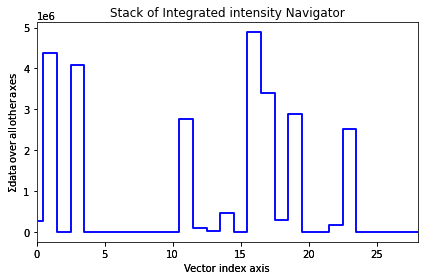

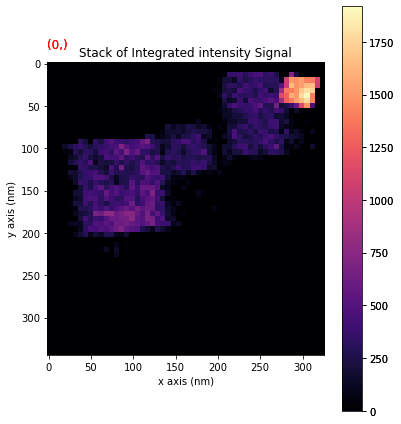

In [44]:
#%matplotlib notebook
VDFs.plot(cmap='magma', scalebar=False)

First find adequate parameters by looking at watershed segmentation of a single VDF image.

In [45]:
from pyxem.utils.segment_utils import separate_watershed

In [46]:
min_distance = 5.5
min_size = 10
max_size = 1000
max_number_of_grains = 1000
marker_radius = 2
exclude_border = 2

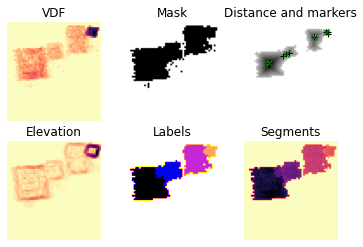

In [47]:
i = 0
sep_i = separate_watershed(
    VDFs.inav[i].data, min_distance=min_distance, min_size=min_size,
    max_size=max_size, max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, marker_radius=marker_radius,
    threshold=True, plot_on=True)

Perform segmentation on all the VDF images

In [48]:
segs = VDFs.get_vdf_segments(min_distance=min_distance,
                             min_size=min_size,
                             max_size = max_size,
                             max_number_of_grains = max_number_of_grains,
                             exclude_border=exclude_border,
                             marker_radius=marker_radius,
                             threshold=True)

print(np.shape(segs.segments)[0],' segments were found.')

[########################################] | 100% Completed |  0.1s
46  segments were found.


/home/cssfrancis/PycharmProjects/pyxem/pyxem/signals/virtual_dark_field_image.py:110: UserWarning: Changed in version 0.15.0.  May cause unexpectederrors related to managing the proper axes.
  warnings.warn(
/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/skimage/filters/thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))
/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/skimage/filters/thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))
/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/skimage/filters/thresholding.py:757: RuntimeWarning: divide by zero encountered in log
  / (np.log(mean_back) - np.log(mean_fore)))


Plot the segments for inspection

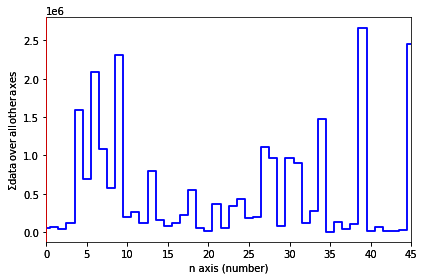

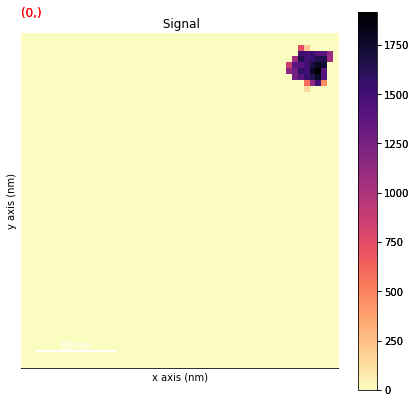

In [49]:
segs.segments.plot(cmap='magma_r')

Calculate normalised cross-correlations between all VDF image segments to identify those that are related to the same crystal.

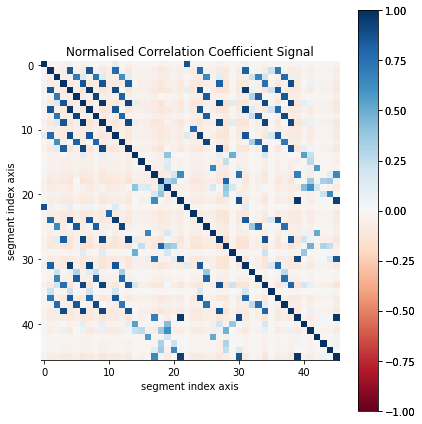

In [50]:
ncc_vdf = segs.get_ncc_matrix()
ncc_vdf.plot(scalebar=False, cmap='RdBu')

If the correlation value exceeds *corr_threshold* for certain segments, those segments are summed. These segments are discarded if the number of these segments are below *vector_threshold*, as this number corresponds to the number of detected diffraction peaks associated with the single crystal. The *vector_threshold* criteria is included to avoid including segment images resulting from noise or incorrect segmentation. 

In [51]:
corr_threshold=0.3
vector_threshold=5
segment_threshold=3

In [52]:
corrsegs = segs.correlate_vdf_segments(
    corr_threshold=corr_threshold, vector_threshold=vector_threshold,
    segment_threshold=segment_threshold)
print(np.shape(corrsegs.segments)[0],' correlated segments were found.')

  0%|                                                    | 0/46 [00:00<?, ?it/s]

5  correlated segments were found.


Simulate virtual diffraction patterns for each summed segment

In [53]:
sigma = scale*1.5

virtual_sig = corrsegs.get_virtual_electron_diffraction(
    calibration=scale, shape=(int(radius_px*2), int(radius_px*2)), sigma=sigma)
virtual_sig.set_diffraction_calibration(scale)

Plot the final results from the VDF image-based segmentation

[<AxesSubplot:title={'center':' (0,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':' (1,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':' (2,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':' (3,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>,
 <AxesSubplot:title={'center':' (4,)'}, xlabel='x axis (nm)', ylabel='y axis (nm)'>]

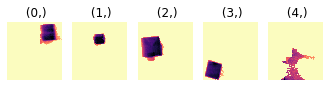

In [54]:
hs.plot.plot_images(corrsegs.segments, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

[<AxesSubplot:title={'center':' (0,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (1,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (2,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (3,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (4,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>]

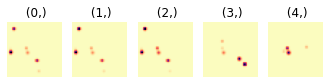

In [55]:
hs.plot.plot_images(virtual_sig, cmap='magma_r', axes_decor='off',
                    per_row=np.shape(corrsegs.segments)[0],
                    suptitle='', scalebar=False, scalebar_color='white',
                    colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right': 0.78})

<a id='nmf'></a> 

## 3. NMF Based Segmentation

### 3.1. NMF Decomposition

Create a signal mask so that the region in the centre of each PED pattern, including the direct beam, can be excluded in the machine learning. 

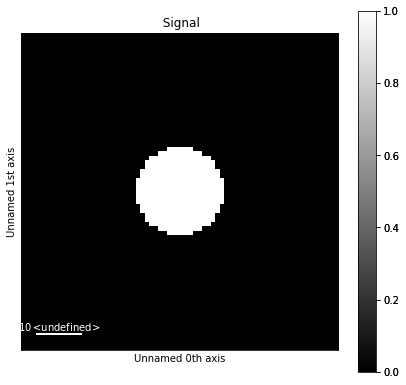

In [56]:
dpm = pxm.signals.Diffraction2D(dp.inav[0,0])
signal_mask = dpm.get_direct_beam_mask(radius=10)
signal_mask.plot()

Perform single value decomposition (SVD)

In [57]:
dp.change_dtype('float32')
dp.decomposition(algorithm='SVD',
                 normalize_poissonian_noise=True,
                 centre=None,
                 signal_mask=signal_mask.data)

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


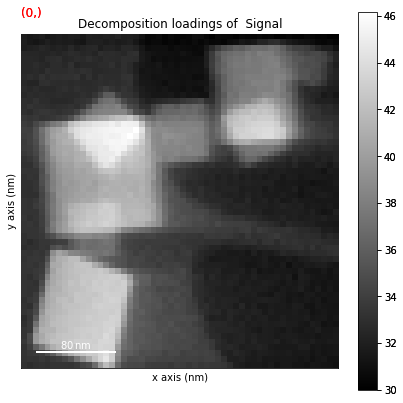

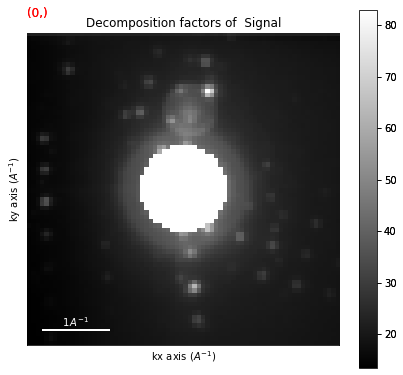

In [58]:
dp.plot_decomposition_results()

Investigate the scree plot and use it as a guide to determine the number of components

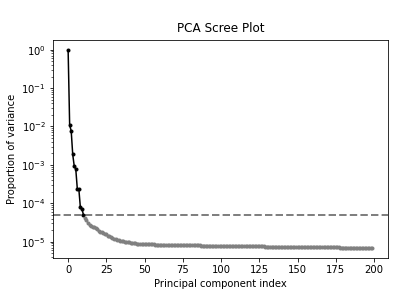

In [59]:
num_comp=11

ax = dp.plot_explained_variance_ratio(n=200, threshold=num_comp,
                                      hline=True, xaxis_labeling='ordinal',
                                      signal_fmt={'color':'k', 'marker':'.'}, 
                                      noise_fmt={'color':'gray', 'marker':'.'})

Perform NMF decomposition with specified number of components

In [60]:
dp.decomposition(normalize_poissonian_noise=True,
                 algorithm='NMF',
                 output_dimension=num_comp,
                 signal_mask=signal_mask.data)

/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Decomposition info:
  normalize_poissonian_noise=True
  algorithm=NMF
  output_dimension=11
  centre=None
scikit-learn estimator:
NMF(n_components=11)


/home/cssfrancis/anaconda3/envs/pyxem39/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [61]:
dp_nmf = dp.get_decomposition_model(components=np.arange(num_comp))
factors = dp_nmf.get_decomposition_factors()
loadings = dp_nmf.get_decomposition_loadings()

Plot the NMF results

[<AxesSubplot:title={'center':' (0,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (1,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (2,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (3,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (4,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (5,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (6,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (7,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (8,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubplot:title={'center':' (9,)'}, xlabel='kx axis ($A^{-1}$)', ylabel='ky axis ($A^{-1}$)'>,
 <AxesSubp

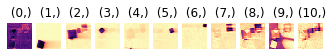

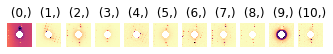

In [62]:
hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off', per_row=11,
             suptitle='', scalebar=False, scalebar_color='white', colorbar=False,
             padding={'top': 0.95, 'bottom': 0.05,
                      'left': 0.05, 'right':0.78})

Discard the components related to background (\#0) and to the carbon film (\#4)

In [63]:
from hyperspy.signals import Signal2D

In [64]:
factors = Signal2D(np.delete(factors.data, [0, 4], axis = 0))
loadings = Signal2D(np.delete(loadings.data, [0, 4], axis = 0))

[<AxesSubplot:title={'center':' (0,)'}>,
 <AxesSubplot:title={'center':' (1,)'}>,
 <AxesSubplot:title={'center':' (2,)'}>,
 <AxesSubplot:title={'center':' (3,)'}>,
 <AxesSubplot:title={'center':' (4,)'}>,
 <AxesSubplot:title={'center':' (5,)'}>,
 <AxesSubplot:title={'center':' (6,)'}>,
 <AxesSubplot:title={'center':' (7,)'}>,
 <AxesSubplot:title={'center':' (8,)'}>]

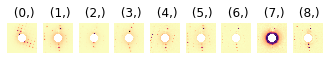

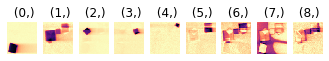

In [65]:
hs.plot.plot_images(factors, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(loadings, cmap='magma_r', axes_decor='off',
                    per_row=9, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

### 3.2. Correlate NMF Loading Maps

NMF often leads to splitting of some crystals into several components. Therefore the correlation between loadings and between component patterns are calculated, and if both the correlation values for loadings and factors exceed threshold values, those loadings and factors are summed. 

Calculate the matrix of normalised cross-correlation for both the loadings and patterns first, to find suitable correlation threshold values. 

In [66]:
from pyxem.signals.segments import LearningSegment
learn = LearningSegment(factors=factors, loadings=loadings)

In [67]:
ncc_nmf = learn.get_ncc_matrix()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


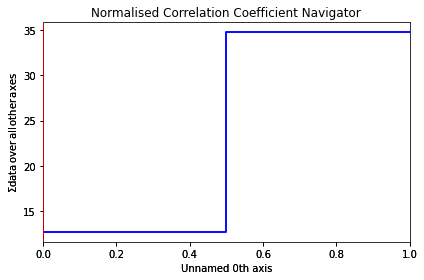

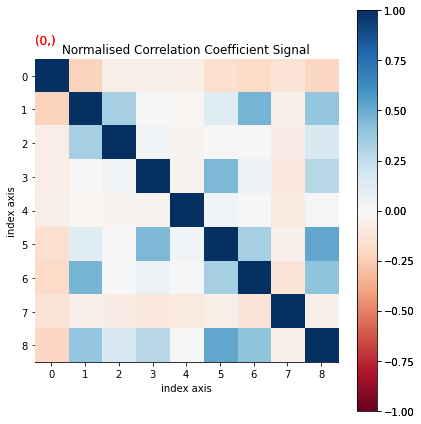

In [68]:
ncc_nmf.plot(scalebar=False, cmap='RdBu')

In [69]:
corr_th_factors = 0.45
corr_th_loadings = 0.3

Perform correlation and summation of the factors and loadings

In [70]:
learn_corr = learn.correlate_learning_segments(corr_th_factors=corr_th_factors,
                                               corr_th_loadings=corr_th_loadings)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


Plot the NMF reuslts after correlation and summation

[<AxesSubplot:title={'center':' (0,)'}>,
 <AxesSubplot:title={'center':' (1,)'}>,
 <AxesSubplot:title={'center':' (2,)'}>,
 <AxesSubplot:title={'center':' (3,)'}>,
 <AxesSubplot:title={'center':' (4,)'}>,
 <AxesSubplot:title={'center':' (5,)'}>,
 <AxesSubplot:title={'center':' (6,)'}>]

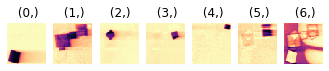

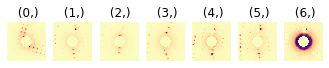

In [71]:
hs.plot.plot_images(learn_corr.loadings, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})
hs.plot.plot_images(learn_corr.factors, cmap='magma_r', axes_decor='off',
                    per_row=7, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

First investigate how the parameters influence the segmentation on
one single loading map.

In [72]:
from pyxem.utils.segment_utils import separate_watershed

In [73]:
min_distance = 10
min_size = 50
max_size = 100000
max_number_of_grains = 100000
marker_radius = 2
exclude_border = 1
threshold = True

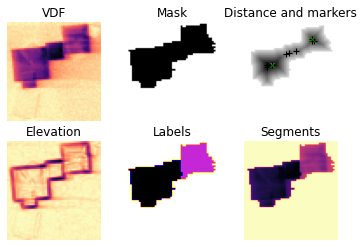

In [74]:
i =1
sep_i = separate_watershed(
    learn_corr.loadings.data[i], min_distance=min_distance,
    min_size=min_size, max_size=max_size, 
    max_number_of_grains=max_number_of_grains,
    exclude_border=exclude_border, 
    marker_radius=marker_radius, threshold=True, plot_on=True)

Set a threshold for the minimum intensity value that a loading segment must contain in order to be kept. 

In [75]:
min_intensity_threshold = 10000

In [76]:
learn_corr_seg = learn_corr.separate_learning_segments(
    min_intensity_threshold=min_intensity_threshold,
    min_distance = min_distance, min_size = min_size,
    max_size = max_size, 
    max_number_of_grains = max_number_of_grains,
    exclude_border = exclude_border,
    marker_radius = marker_radius, threshold = True)

[########################################] | 100% Completed |  0.1s


Plot the final results from the NMF-based segmentation

In [77]:
hs.plot.plot_images(learn_corr_seg.loadings, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

hs.plot.plot_images(learn_corr_seg.factors, 
                    cmap='magma_r', axes_decor='off',
                    per_row=10, suptitle='', scalebar=False,
                    scalebar_color='white', colorbar=False,
                    padding={'top': 0.95, 'bottom': 0.05,
                             'left': 0.05, 'right':0.78})

[]

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>